1 | Import Libraries and Dataset

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
!pip install evaluate
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
columns = ['question', 'answer']

df = pd.read_csv('/content/dialogs (1).AI_RULE.txt', sep='\t', names=columns)

# Now df will have columns named 'question' and 'answer'
df.head()

,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


2 | EDA

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

2.1. Basic Exploration:
Check the data types of columns.

Get an overview of the dataset's shape (number of rows and columns).

Check for any missing values.

In [ ]:
print("\nData types of columns:")
print(df.dtypes)
print("\nShape of the dataset:")
print(df.shape)
print("\nMissing values:")
print(df.isnull().sum())


Data types of columns:
question    object
answer      object
dtype: object

Shape of the dataset:
(3725, 2)

Missing values:
question    0
answer      0
dtype: int64


2.2. Text Analysis:
Analyze the length distribution of questions and answers.

Check for any unusual characters or patterns in the text.

Explore the most common words or phrases in questions and answers (word frequency analysis).

In [ ]:
# Length distribution of questions and answers
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)

In [ ]:
df.head()

,question,answer,question_length,answer_length
0,"hi, how are you doing?",i'm fine. how about yourself?,22,29
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,29,35
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,35,33
3,no problem. so how have you been?,i've been great. what about you?,33,32
4,i've been great. what about you?,i've been good. i'm in school right now.,32,40


2.3. Visualization:

Create visualizations to better understand the data distribution (e.g., histograms, word clouds).

Plot the distribution of question and answer lengths.

Visualize word frequency using bar plots or word clouds.

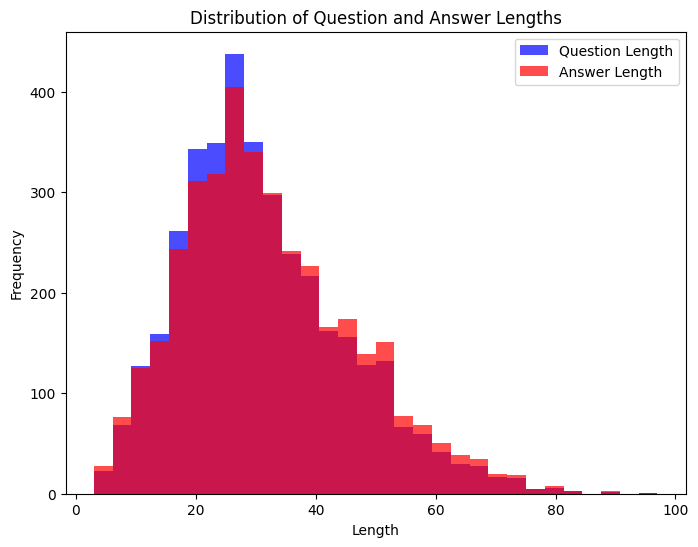

In [ ]:
# Visualization
plt.figure(figsize=(8, 6))
plt.hist(df['question_length'], bins=30, alpha=0.7, color='blue', label='Question Length')
plt.hist(df['answer_length'], bins=30, alpha=0.7, color='red', label='Answer Length')
plt.title('Distribution of Question and Answer Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

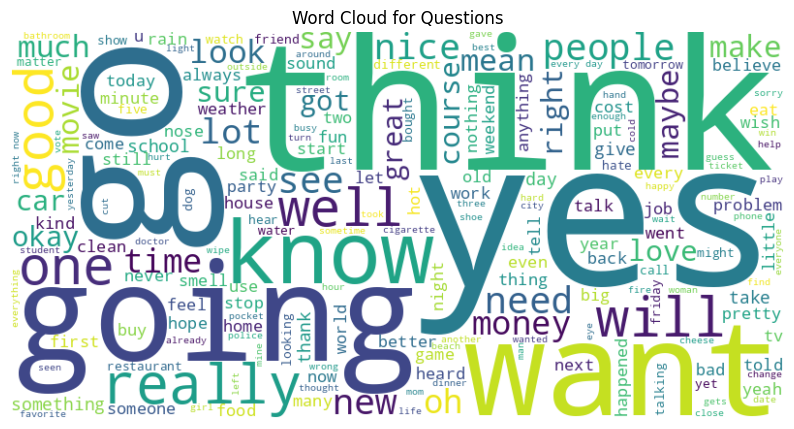

In [ ]:
# Word cloud for questions
question_text = ' '.join(df['question'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(question_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')
plt.show()

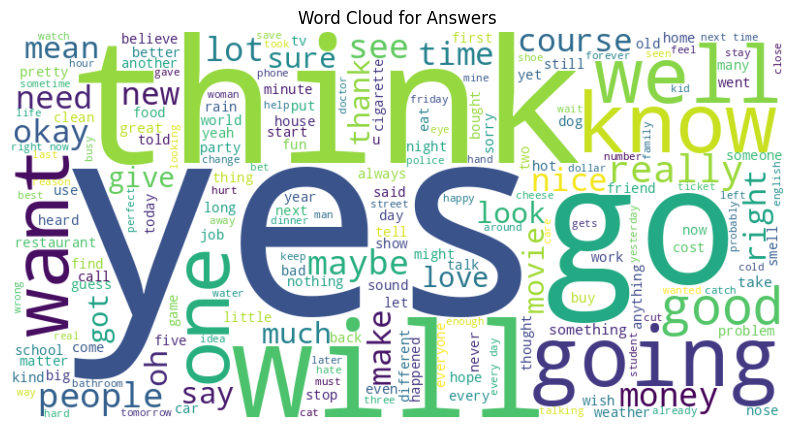

In [ ]:
# Word cloud for answers
answer_text = ' '.join(df['answer'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(answer_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Answers')
plt.axis('off')
plt.show()

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

2.4. Topic Modeling:

Use techniques like Latent Dirichlet Allocation (LDA) to identify underlying topics in the questions and answers.

Cluster similar questions and answers based on topic distributions.

In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['question'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
# Display the top words for each topic
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:", ", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]))

Topic 0: think, really, time, maybe, mean, ve, ll, better, let, doing
Topic 1: like, yes, want, didn, day, right, say, does, going, just
Topic 2: good, know, don, need, sure, course, great, job, new, haven
Topic 3: did, people, lot, school, don, today, really, yes, oh, think
Topic 4: ll, going, okay, nice, money, got, just, think, make, car


2.5. Language Complexity:

Measure the complexity of language used in questions and answers (e.g., average word length, vocabulary richness).

Explore readability scores or linguistic features.

In [ ]:
df['question_word_count'] = df['question'].apply(lambda x: len(x.split()))
df['answer_word_count'] = df['answer'].apply(lambda x: len(x.split()))

# Analyze language complexity
avg_question_word_length = df['question'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()
avg_answer_word_length = df['answer'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split())).mean()

print("\nAverage word length in questions:", avg_question_word_length)
print("Average word length in answers:", avg_answer_word_length)


Average word length in questions: 4.166015845093442
Average word length in answers: 4.175336153968232


3 | Data Preprocessing

3.1. Data Augmentation (UPSampling)

In [ ]:
# Define the new dialogue data
new_dialogue_data = [
    ["Hi", "Hello"],
    ["How are you?", "I'm good, thanks for asking. How about you?"],
    ["I'm doing well too.", "That's great to hear. What have you been up to lately?"],
    ["Not much, just working and spending time with family.", "That sounds nice. Have you watched any good movies recently?"],
    ["Yeah, I saw a really good one last weekend.", "It was a thriller, right? I heard good things about it."],
    ["Yes, it was.", "Do you want to watch it together sometime?"],
    ["Sure, that sounds like a plan.", "Awesome! Let's plan it for this weekend."],
    ["Sounds good to me.", "Alright then, it's a plan. What time works for you?"],
    ["How about Saturday evening?", "Perfect! Saturday evening it is. I'll book the tickets."],
    ["Great! Looking forward to it.", "Me too. It'll be fun."]
]
new_df = pd.DataFrame(new_dialogue_data, columns=columns)

# Concatenate the new DataFrame with the existing DataFrame
df = pd.concat([df, new_df], ignore_index=True)

# Print the updated DataFrame
df

,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,"hi, how are you doing?",i'm fine. how about yourself?,22.0,29.0,5.0,5.0
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,29.0,35.0,5.0,6.0
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,35.0,33.0,6.0,7.0
3,no problem. so how have you been?,i've been great. what about you?,33.0,32.0,7.0,6.0
4,i've been great. what about you?,i've been good. i'm in school right now.,32.0,40.0,6.0,8.0
...,...,...,...,...,...,...
3730,"Yes, it was.",Do you want to watch it together sometime?,NaN,NaN,NaN,NaN
3731,"Sure, that sounds like a plan.",Awesome! Let's plan it for this weekend.,NaN,NaN,NaN,NaN
3732,Sounds good to me.,"Alright then, it's a plan. What time works for...",NaN,NaN,NaN,NaN
3733,How about Saturday evening?,Perfect! Saturday evening it is. I'll book the...,NaN,NaN,NaN,NaN


3.2. Preprocessing

Lowercase

Tokenization

Stop words removal

Lemmization

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
#     tokens = word_tokenize(text)
#     tokens = [word for word in tokens if word.isalnum()]
#     preprocessed_text = ' '.join(tokens)

    return text

# Apply preprocessing to question and answer columns
preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

# Print the preprocessed DataFrame
preprocessed_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,"hi, how are you doing?",i'm fine. how about yourself?,22.0,29.0,5.0,5.0
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,29.0,35.0,5.0,6.0
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,35.0,33.0,6.0,7.0
3,no problem. so how have you been?,i've been great. what about you?,33.0,32.0,7.0,6.0
4,i've been great. what about you?,i've been good. i'm in school right now.,32.0,40.0,6.0,8.0
...,...,...,...,...,...,...
3730,"yes, it was.",do you want to watch it together sometime?,NaN,NaN,NaN,NaN
3731,"sure, that sounds like a plan.",awesome! let's plan it for this weekend.,NaN,NaN,NaN,NaN
3732,sounds good to me.,"alright then, it's a plan. what time works for...",NaN,NaN,NaN,NaN
3733,how about saturday evening?,perfect! saturday evening it is. i'll book the...,NaN,NaN,NaN,NaN


4 | Classical ML ChatBot

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_df['question'], preprocessed_df['answer'], test_size=0.2, random_state=42, shuffle=True)

4.1. Model Pipline and training

In [ ]:
Pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

Pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [ ]:
Pipe.predict(['where are you going'])[0]

'we went to a nice restaurant.'

4.2. Model Evaluation

In [ ]:
# Predicting text using the pipeline on the test set
predicted_text = Pipe.predict(X_test)

# Creating a DataFrame to compare the first 10 results
comparison_df = pd.DataFrame({'Real Question ': X_test[:10],'Real Generated Text': y_test[:10], 'Predicted Text': predicted_text[:10]})
comparison_df.head(10)

,Real Question,Real Generated Text,Predicted Text
3253,how are you doing that?,i started shopping at the dollar store.,i'm doing great. what about you?
3190,"the pants are fine, but the pocket has a huge ...",you shouldn't carry your keys and pens in your...,"you do this 18 times, because there are 18 holes."
2194,uh-oh. that means that she's fat and ugly.,she's cute.,men singers don't have to look good.
3303,that's great. we won't have neighbors on both ...,no pets are allowed.,"if they don't like it, they can move."
642,"i really wanted you to come, but i understand.","yeah, maybe next time.",i have things to do.
3214,that's a good deal.,and a one-pound tub of soft butter was the sam...,"yes, even though some of the potatoes had eyes."
184,she's one of the prettiest girls at the school.,what does she look like?,maybe we should learn some good jokes.
3515,"no, that's not the problem.",maybe it will go away in a little while.,someone cut the tires.
3185,why not?,i didn't want to pay for the holes.,they might think i'm stupid.
2206,eight o'clock.,that sounds great.,i have the dvd.


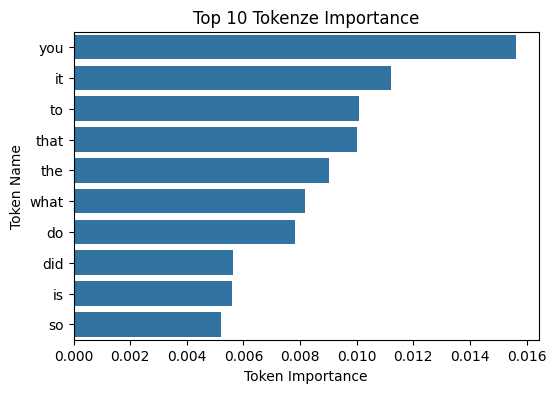

In [ ]:
#1233	really? how many do you have?	i don't know, maybe one hundred.	eleven cars.
import seaborn as sns

# Visualize Feature Importance
if isinstance(Pipe.named_steps['classifier'], RandomForestClassifier):
    feature_importances = Pipe.named_steps['classifier'].feature_importances_
    feature_names = Pipe.named_steps['tfidf'].get_feature_names_out()

    # Sort feature importances
    sorted_indices = feature_importances.argsort()[::-1]
    top_feature_importances = feature_importances[sorted_indices][:10]
    top_feature_names = np.array(feature_names)[sorted_indices][:10]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=top_feature_importances, y=top_feature_names)
    plt.xlabel('Token Importance')
    plt.ylabel('Token Name')
    plt.title('Top 10 Tokenze Importance')
    plt.show()

4.3. Chat with you ChatBot :D

In [ ]:

# Uncomment this cell to try it :)


# Function to get response from chatbot
def get_response(question):
    response = Pipe.predict([question])[0]
    return response

# Function to interact with the user
def chat():
    while True:
        question = input("You: ")
        if question.lower() == 'quit':
            print("Chatbot: Goodbye!")
            break
        response = get_response(question)
        print("Chatbot:", response)

# Start the chat
chat()

You: how are you
Chatbot: i'm good, thanks for asking. how about you?
You: what are you doing
Chatbot: i'm going to change the light bulb. it burnt out.
You: then
Chatbot: then we'll just make a u-turn.
You: ok
Chatbot: can you fix a dripping faucet in a kitchen sink?
You: quite
Chatbot: how tall would you say that she is?
You: quit
Chatbot: Goodbye!


5 | Encoder - Decoder Model with Attention and LSTMs Chatbot from scratch ¶

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate

5.1. Seq2Seq Text Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import unicodedata


nltk.download('punkt')

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Function for preprocessing text
def preprocess_text(text):
    # Convert text to lowercase
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub("(\\W)"," ",text)
    text = re.sub('\S*\d\S*\s*','', text)
    text =  "<sos> " +  text + "<eos>"
    return text

# Apply preprocessing to question and answer columns
preprocessed_df = df.copy()
preprocessed_df['question'] = preprocessed_df['question'].apply(preprocess_text)
preprocessed_df['answer'] = preprocessed_df['answer'].apply(preprocess_text)

# Print the preprocessed DataFrame
preprocessed_df

<>:19: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-462955023.py:19: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('\S*\d\S*\s*','', text)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,question,answer,question_length,answer_length,question_word_count,answer_word_count
0,<sos> hi how are you doing <eos>,<sos> i m fine how about yourself <eos>,22.0,29.0,5.0,5.0
1,<sos> i m fine how about yourself <eos>,<sos> i m pretty good thanks for asking <eos>,29.0,35.0,5.0,6.0
2,<sos> i m pretty good thanks for asking <eos>,<sos> no problem so how have you been <eos>,35.0,33.0,6.0,7.0
3,<sos> no problem so how have you been <eos>,<sos> i ve been great what about you <eos>,33.0,32.0,7.0,6.0
4,<sos> i ve been great what about you <eos>,<sos> i ve been good i m in school right now ...,32.0,40.0,6.0,8.0
...,...,...,...,...,...,...
3730,<sos> yes it was <eos>,<sos> do you want to watch it together sometim...,NaN,NaN,NaN,NaN
3731,<sos> sure that sounds like a plan <eos>,<sos> awesome let s plan it for this weekend ...,NaN,NaN,NaN,NaN
3732,<sos> sounds good to me <eos>,<sos> alright then it s a plan what time wor...,NaN,NaN,NaN,NaN
3733,<sos> how about saturday evening <eos>,<sos> perfect saturday evening it is i ll bo...,NaN,NaN,NaN,NaN


5.2. Tokenizer

In [ ]:
# Preprocessing the data
questions = preprocessed_df['question'].values.tolist()
answers = preprocessed_df['answer'].values.tolist()

# Tokenizing the data
keras_tokenizer = Tokenizer(filters='')
keras_tokenizer.fit_on_texts(np.concatenate((questions, answers), axis=0))

vocab_size = len(keras_tokenizer.word_index) + 1

# Convert text to sequences
question_seqs = keras_tokenizer.texts_to_sequences(questions)
answer_seqs = keras_tokenizer.texts_to_sequences(answers)

# Padding sequences for equal length
# Pad sequences for equal length
max_len_question = max(len(seq) for seq in question_seqs)
max_len_answer = max(len(seq) for seq in answer_seqs)
max_len = max(max_len_question, max_len_answer)
print(max(max_len_question, max_len_answer))
# Pad sequences separately for questions and answers
question_seqs = pad_sequences(question_seqs, maxlen=max_len, padding='post')
answer_seqs = pad_sequences(answer_seqs, maxlen=max_len, padding='post')

22


In [ ]:
keras_tokenizer.texts_to_sequences("<sos>")

[[], [9], [490], [9], []]

In [ ]:
keras_tokenizer.word_index["<sos>"]

1

5.3. Model Architecture

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate, Dropout

# Define the model architecture
latent_dim = 256  # Dimensionality of the encoding space

# Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len,))
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding(encoder_inputs))
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len-1,))
decoder_embedding = Embedding(vocab_size, latent_dim, input_shape=(max_len-1,))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.1, recurrent_dropout=0.1)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding(decoder_inputs), initial_state=encoder_states)

# Attention mechanism
attention_layer = Attention()
attention_output = attention_layer([decoder_outputs, encoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Add dropout layer for regularization
decoder_concat_input = Dropout(0.1)(decoder_concat_input)

# Output layer
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5.4. Model Training

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Increased patience

# Print model summary
model.summary()

# Train the model
history=model.fit([question_seqs, answer_seqs[:, :-1]], answer_seqs[:, 1:],
          batch_size=64,
          epochs=100, # Increased epochs
          validation_split=0.2, callbacks=[early_stopping])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 256)   │    618,496 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 21, 256)   │    618,496 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 22, 256), │    525,312 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 21, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 21, 256)   │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 21, 512)   │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 21, 512)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 21, 2416)  │  1,239,408 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,527,024 (13.45 MB)

 Trainable params: 3,527,024 (13.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.8684 - val_loss: 2.2689
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 0.8226 - val_loss: 2.3030
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.7833 - val_loss: 2.3275
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.7596 - val_loss: 2.3737
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - loss: 0.7093 - val_loss: 2.4051
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 0.6791 - val_loss: 2.4241
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - loss: 0.6512 - val_loss: 2.4467
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - loss: 0.6246 - val_loss: 2.4759
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 0.5972 - val_loss: 2.4977
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 0.5700 - val_loss: 2.5282
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 0.5551 - val_loss: 2.5513


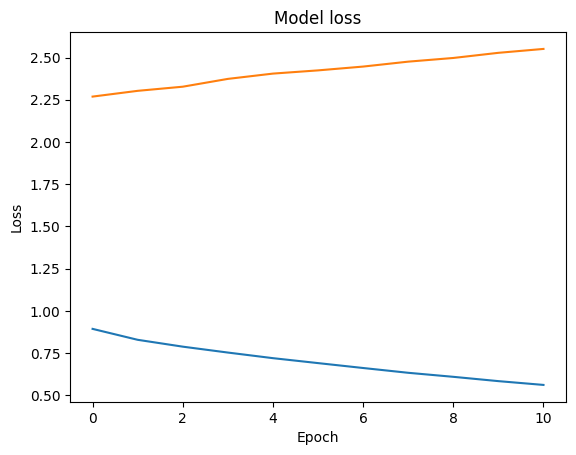

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model.save('model_weights.h5')

# Task
Generate a Keras Encoder-Decoder chatbot using the previously trained `model_weights.h5` model to answer user questions, then create and launch a Gradio interface to interact with the chatbot.

## Load Model for Inference

### Subtask:
Load the pre-trained Keras model weights from `model_weights.h5` and reconstruct the inference model architecture.


**Reasoning**:
First, I will reconstruct the original Keras model and load the saved weights from 'model_weights.h5' to ensure the base model is ready. Then, I will define the encoder model for inference, which extracts the final states and outputs from the encoder. Finally, I will define the decoder model for inference, which takes the encoder's outputs and states to generate new sequences, incorporating the attention mechanism as described.



In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.load_weights('model_weights.h5')

# Create an encoder model for inference
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Create a decoder model for inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
encoder_outputs_as_input = Input(shape=(max_len, latent_dim))

decoder_input = Input(shape=(1,))
decoder_embedding_inf = decoder_embedding(decoder_input)

decoder_outputs_inf, state_h_decoder, state_c_decoder = decoder_lstm(
    decoder_embedding_inf, initial_state=[decoder_state_input_h, decoder_state_input_c])

attention_output_inf = attention_layer([decoder_outputs_inf, encoder_outputs_as_input])
decoder_concat_input_inf = Concatenate(axis=-1)([decoder_outputs_inf, attention_output_inf])
decoder_concat_input_inf = Dropout(0.1)(decoder_concat_input_inf)

final_decoder_outputs_inf = decoder_dense(decoder_concat_input_inf)

decoder_model = Model(
    [
        decoder_input,
        encoder_outputs_as_input,
        decoder_state_input_h,
        decoder_state_input_c
    ],
    [
        final_decoder_outputs_inf,
        state_h_decoder,
        state_c_decoder
    ]
)

print("Models loaded and inference models created successfully.")

Models loaded and inference models created successfully.


## Define Inference Functions

### Subtask:
Create functions for encoding input sequences, decoding output sequences step-by-step using the encoder and decoder models, and reconstructing the text from token IDs.


**Reasoning**:
I will define the `decode_sequence` function to handle the step-by-step decoding process using the previously constructed encoder and decoder models. This function will take an encoded input sequence, predict the next tokens, and reconstruct the answer until an end-of-sequence token is encountered or a maximum length is reached.



In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    encoder_output, h, c = encoder_model.predict(input_seq)
    encoder_states = [h, c]

    # Generate empty target sequence of length 1 with the start token
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = keras_tokenizer.word_index['<sos>']

    # Populate the output sequence
    decoded_sentence = []
    for _ in range(max_len):
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_output, h, c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = keras_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<eos>':
            break

        decoded_sentence.append(sampled_word)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        encoder_states = [h, c]

    return ' '.join(decoded_sentence)

**Reasoning**:
I will define the `preprocess_input` function, which will take a raw text input, apply the same preprocessing steps as used for the training data, convert it to a sequence of token IDs, and pad it to the maximum length. This is necessary to prepare user input for the chatbot model.



In [ ]:
def preprocess_input(input_text):
    # Apply the same preprocessing steps as for training data
    processed_text = preprocess_text(input_text)
    # Convert to sequence of token IDs
    input_seq = keras_tokenizer.texts_to_sequences([processed_text])
    # Pad the sequence to max_len
    input_seq_padded = pad_sequences(input_seq, maxlen=max_len, padding='post')
    return input_seq_padded

**Reasoning**:
I will define the `preprocess_input` function, which will take a raw text input, apply the same preprocessing steps as used for the training data, convert it to a sequence of token IDs, and pad it to the maximum length. This is necessary to prepare user input for the chatbot model.



In [ ]:
def preprocess_input(input_text):
    # Apply the same preprocessing steps as for training data
    processed_text = preprocess_text(input_text)
    # Convert to sequence of token IDs
    input_seq = keras_tokenizer.texts_to_sequences([processed_text])
    # Pad the sequence to max_len
    input_seq_padded = pad_sequences(input_seq, maxlen=max_len, padding='post')
    return input_seq_padded

## Create Gradio Interface

### Subtask:
Build a Gradio interface (gr.Interface) that takes user input (questions), passes them through the inference pipeline, and displays the generated answers.


**Reasoning**:
To build the Gradio interface, I need to first import the `gradio` library, then define a wrapper function that orchestrates the preprocessing and decoding steps for the chatbot, and finally, instantiate and launch the Gradio interface using this wrapper function.



In [ ]:
import gradio as gr

def chatbot_response(user_input):
    # Preprocess the user's question
    input_seq_padded = preprocess_input(user_input)
    # Get the chatbot's response
    response = decode_sequence(input_seq_padded)
    return response

# Create the Gradio interface
iface = gr.Interface(
    fn=chatbot_response,
    inputs=gr.Textbox(lines=2, placeholder="Type your question here..."),
    outputs="text",
    title="Encoder-Decoder Chatbot with Attention",
    description="Ask the chatbot anything!"
)

# Launch the interface
iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://533c73e7d5f12ae542.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
